# Step 0.0. Install LightAutoML

In [1]:
!pip install -U lightautoml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.6/319.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.2/465.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 56.8 MB/s

# Step 0.1. Import necessary libraries 

In [2]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# repair logger in Kaggle
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

# Step 0.2. Parameters 

In [3]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 600 # Time in seconds for automl run
TARGET_NAME = 'final_price' # Target column name

# Step 0.3. Data load 

In [4]:
%%time

train_data = pd.read_csv('../input/lightautomlcourse-hw1/train_data.csv')
train_data.head()

CPU times: user 109 ms, sys: 53.5 ms, total: 162 ms
Wall time: 243 ms


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [5]:
test_data = pd.read_csv('../input/lightautomlcourse-hw1/test_data.csv')
test_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [6]:
submission = pd.read_csv('../input/lightautomlcourse-hw1/sample_submission.csv')
submission.head()

,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


# Step 0.4. Some user feature preparation 

Be creative :)

In [7]:
%%time

def create_expert_feats(data):
    pass

create_expert_feats(train_data)
create_expert_feats(test_data)

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 25.5 µs


In [8]:
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


# ========= AutoML preset usage =========


## Step 1. Create Task

In [9]:
%%time

task = Task('reg', )

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.92 ms


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [10]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['row_ID'] # to drop or not to drop?
         }

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


## Step 3. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_2_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [11]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

INFO:root:oof_pred:
array([[ 4559.6064],
       [ 6740.676 ],
       [ 8503.059 ],
       ...,
       [12520.437 ],
       [10395.836 ],
       [ 7207.672 ]], dtype=float32)
Shape = (35000, 1)


CPU times: user 21min 23s, sys: 1min 21s, total: 22min 44s
Wall time: 6min 9s


CPU times: user 162 ms, sys: 68 ms, total: 230 ms
Wall time: 143 ms


<AxesSubplot:xlabel='Feature'>

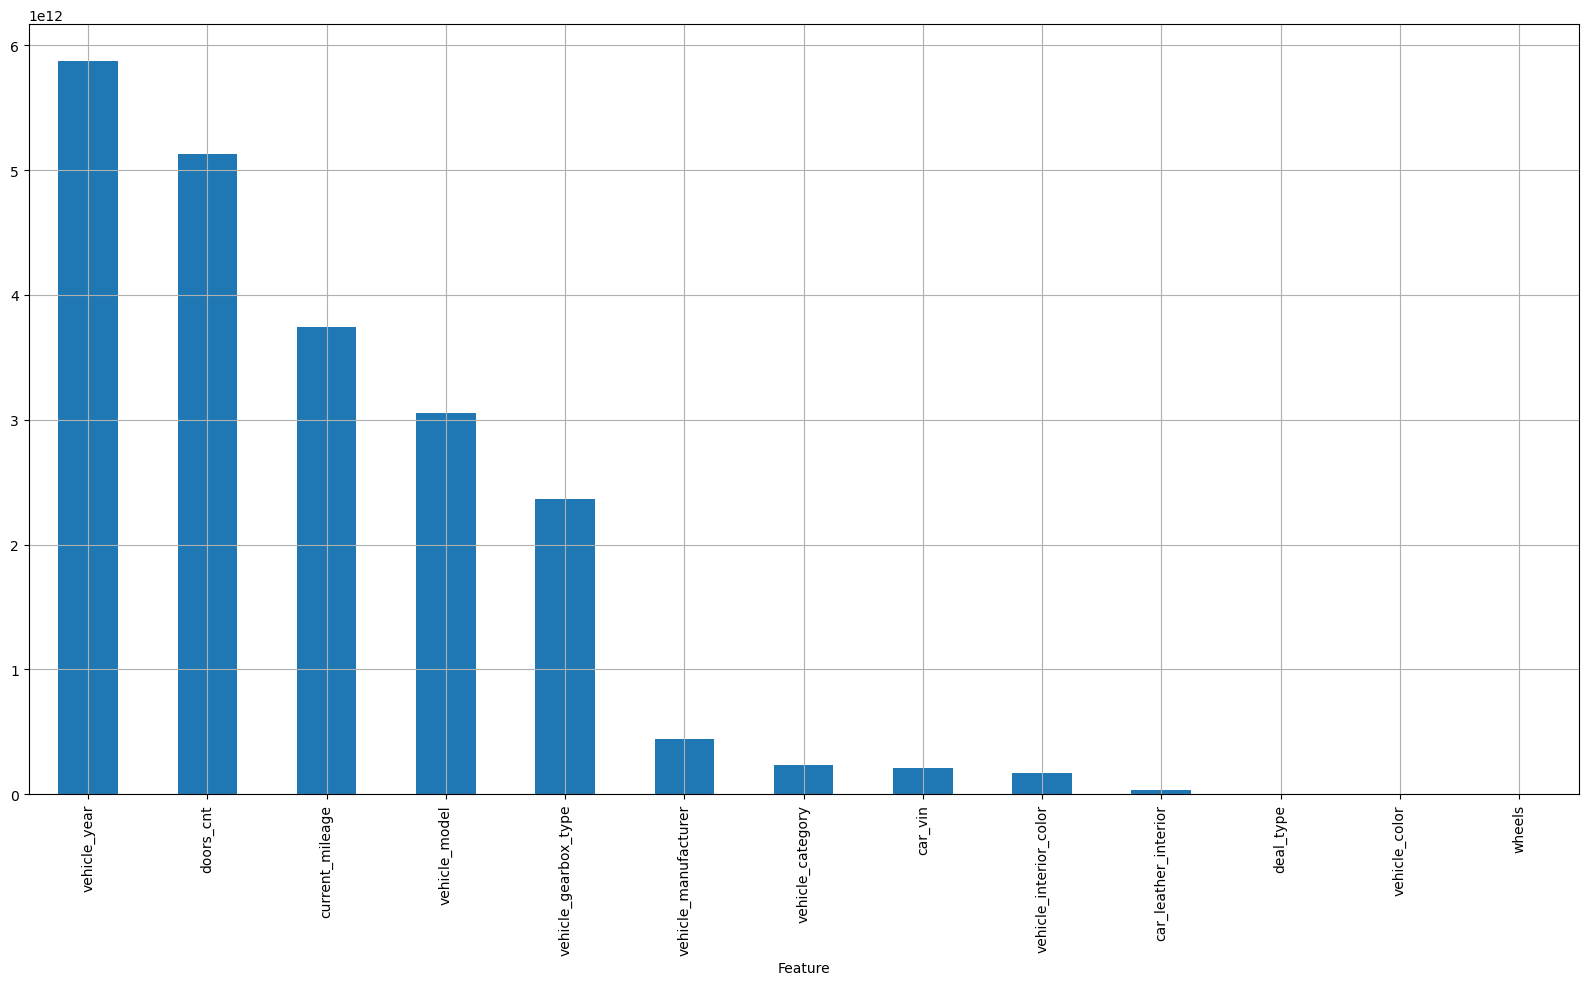

In [12]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Predict to test data and check scores

In [13]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

INFO:root:Prediction for test data:
array([[ 3831.561 ],
       [ 7154.4194],
       [ 6353.3403],
       ...,
       [10449.239 ],
       [ 5028.6543],
       [ 7293.8564]], dtype=float32)
Shape = (10697, 1)
INFO:root:Check scores...
INFO:root:OOF score: 3760.3261368013655


CPU times: user 1.5 s, sys: 32.2 ms, total: 1.54 s
Wall time: 1.02 s


## Step 5. Generate submission

In [14]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.head()

,row_ID,final_price
0,35000,3831.561035
1,35001,7154.419434
2,35002,6353.340332
3,35003,4003.982422
4,35004,6815.704590


In [15]:
submission.to_csv('lightautoml_sample_submission.csv', index = False)